# MNIST '4' theoretical & practical representative images

In [1]:

# Minimal setup: imports, config, loader, and helpers
%matplotlib widget

import os, gzip, struct, urllib.request
import numpy as np
import matplotlib.pyplot as plt

# MNIST IDX mirror + cache
DATA_DIR = os.path.join(os.path.expanduser("~"), ".cache", "mnist_idx")
USE_MIRROR = "https://storage.googleapis.com/cvdf-datasets/mnist/"
FILES = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}

LABEL_OF_INTEREST = 4
GEOMED_MAX_ITERS = 1000
GEOMED_TOL = 1e-7
GEOMED_SUBSAMPLE = None  # set to e.g. 3000 if geomedian is slow

def _download_if_needed():
    os.makedirs(DATA_DIR, exist_ok=True)
    for fn in FILES.values():
        path = os.path.join(DATA_DIR, fn)
        if not os.path.exists(path):
            urllib.request.urlretrieve(USE_MIRROR + fn, path)

def _read_idx_images(path_gz):
    with gzip.open(path_gz, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic for images: {magic}")
        arr = np.frombuffer(f.read(rows * cols * n), dtype=np.uint8)
        return arr.reshape(n, rows, cols)

def _read_idx_labels(path_gz):
    with gzip.open(path_gz, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic for labels: {magic}")
        return np.frombuffer(f.read(n), dtype=np.uint8)

def load_mnist_all():
    _download_if_needed()
    paths = {k: os.path.join(DATA_DIR, v) for k, v in FILES.items()}
    x_tr = _read_idx_images(paths["train_images"]).astype(np.float32) / 255.0
    y_tr = _read_idx_labels(paths["train_labels"])
    x_te = _read_idx_images(paths["test_images"]).astype(np.float32) / 255.0
    y_te = _read_idx_labels(paths["test_labels"])
    X = np.concatenate([x_tr, x_te], axis=0)
    y = np.concatenate([y_tr, y_te], axis=0)
    return X, y

def geometric_median_weiszfeld(X, max_iters=1000, tol=1e-7):
    X = np.asarray(X, dtype=np.float64)
    x = np.median(X, axis=0)
    if not np.all(np.isfinite(x)):
        x = np.mean(X, axis=0)
    eps = 1e-12
    for _ in range(max_iters):
        diffs = X - x
        dists = np.linalg.norm(diffs, axis=1)
        hit = np.where(dists < eps)[0]
        if hit.size:
            return X[hit[0]].copy()
        w = 1.0 / np.maximum(dists, eps)
        x_new = (w[:, None] * X).sum(axis=0) / w.sum()
        if np.linalg.norm(x_new - x) < tol:
            return x_new
        x = x_new
    return x

def svd_basis(A):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    tol = s[0] * max(A.shape) * np.finfo(float).eps if s.size > 0 else 0.0
    r = int(np.sum(s > tol)) if s.size > 0 else 0
    if r == 0 and s.size > 0:
        r = 1
    return U[:, :r], s[:r], Vt[:r]


In [2]:

# Compute theory reps for label 4 and choose practical reps using the PAPER method
X_all, y_all = load_mnist_all()
X4 = X_all[y_all == LABEL_OF_INTEREST]        # (N, 28, 28)
N, H, W = X4.shape
X4_flat = X4.reshape(N, H*W)                  # (N, 784)

# Theoretical centers (pixel space)
mean_vec   = np.mean(X4_flat, axis=0)
median_vec = np.median(X4_flat, axis=0)
if GEOMED_SUBSAMPLE is not None and GEOMED_SUBSAMPLE < X4_flat.shape[0]:
    rng = np.random.default_rng(123)
    take = rng.choice(X4_flat.shape[0], size=GEOMED_SUBSAMPLE, replace=False)
    X_geo = X4_flat[take]
else:
    X_geo = X4_flat
geomed_vec = geometric_median_weiszfeld(X_geo, max_iters=GEOMED_MAX_ITERS, tol=GEOMED_TOL)

theory = {
    "mean": mean_vec.reshape(H, W),
    "median": median_vec.reshape(H, W),
    "geom_median": geomed_vec.reshape(H, W)
}

# SVD basis over all '4's
A = X4_flat.T                               # (784, N) columns are images
U_r, s_r, Vt_r = svd_basis(A)               # U_r: (784, r)
C = U_r.T @ X4_flat.T                       # (r, N) coordinates of all real images

def nearest_in_basis(xT_vec):
    cT = U_r.T @ xT_vec                     # (r,)
    dists = np.linalg.norm(C.T - cT[None, :], axis=1)
    idx = int(np.argmin(dists))
    return idx, float(dists[idx])

chosen = {}
for name, vec in {"mean": mean_vec, "median": median_vec, "geomedian": geomed_vec}.items():
    idx, dist = nearest_in_basis(vec)
    chosen[name] = (idx, dist)


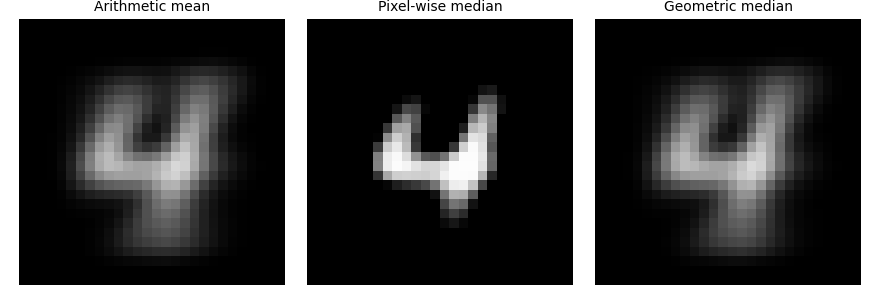

In [3]:

#| label: fig:mnist-four-theory
#| caption: "MNIST '4' theoretical representatives: mean (left), median (middle), geometric median (right)."
fig, axes = plt.subplots(1, 3, figsize=(8.8, 3))
for ax, key, ttl in zip(
    axes,
    ["mean", "median", "geom_median"],
    ["Arithmetic mean", "Pixel-wise median", "Geometric median"]
):
    ax.imshow(np.clip(theory[key], 0, 1), cmap="gray", vmin=0, vmax=1)
    ax.set_title(ttl, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()


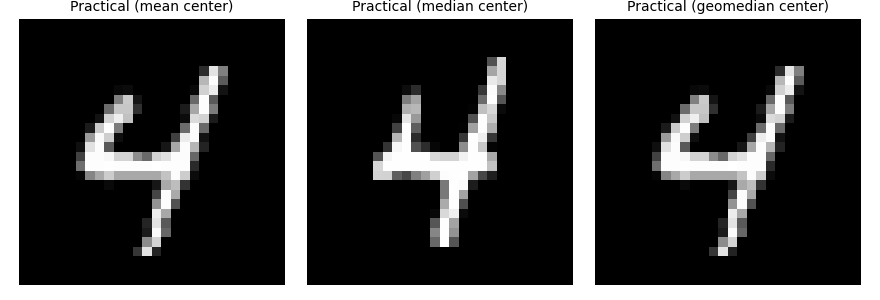

In [4]:

#| label: fig:mnist-four-practical
#| caption: "Practical representatives for MNIST '4' via PAPER method (nearest in SVD-basis coords): mean-based (left), median-based (middle), geometric-median-based (right)."
fig, axes = plt.subplots(1, 3, figsize=(8.8, 3))
for ax, key, ttl in zip(
    axes,
    ["mean", "median", "geomedian"],
    ["Practical (mean center)", "Practical (median center)", "Practical (geomedian center)"]
):
    idx, _ = chosen[key]
    ax.imshow(X4[idx], cmap="gray", vmin=0, vmax=1)
    ax.set_title(ttl, fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()
